## Procesamiento del Lenguaje Natural 1
### Carrera de Especialización en Inteligencia Artificial - FIUBA

## Desafío N° 1
### Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

### 2º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |


### Consigna

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámetros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.


### 0. Preliminar

#### 0.1 Librerías

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt

# For modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

# Dataset
# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import nltk
from nltk.corpus import stopwords

#### 0.2 Carga de datos

In [2]:
# Cargamos el set de train/test
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Descargamos "stopwords" de NLTK
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\badesia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Explicación del input 'remove':

- 'Headers' remueve los encabezados
- 'Footers' remueve bloques al final correspondientes a la firma del post
- 'Quotes' remueve las líneas que citan otros posteos.

Respecto de NLTK, removemos palabras comunes como "the", "is", "in", etc., para reducir ruido.

Veamos la descripción del corpus:

In [3]:
print(newsgroups_train.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1

**Observaciones**:

- Cantidad de clases: 20
- Cantidad de documentos del *corpus* (train + test): 18846 

Verificamos esos datos más abajo...

In [4]:
ntrain = len(newsgroups_train.data)
ntest = len(newsgroups_test.data)
ndata = ntrain + ntest

print('Cantidad de datos de train: ', ntrain)
print('Cantidad de datos de test: ', ntest)
print('Cantidad de datos totales: ', ndata)
print(f'Fracción de datos de train: {ntrain/ndata:.2f}')
print(f'Fracción de datos de test: {ntest/ndata:.2f}')

Cantidad de datos de train:  11314
Cantidad de datos de test:  7532
Cantidad de datos totales:  18846
Fracción de datos de train: 0.60
Fracción de datos de test: 0.40


In [5]:
# Veamos cantidad de clases
print(f'clases {np.unique(newsgroups_test.target)}')

# Nombres de las clases
target_names = newsgroups_train.target_names
target_names

clases [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
nclasses = len(target_names)

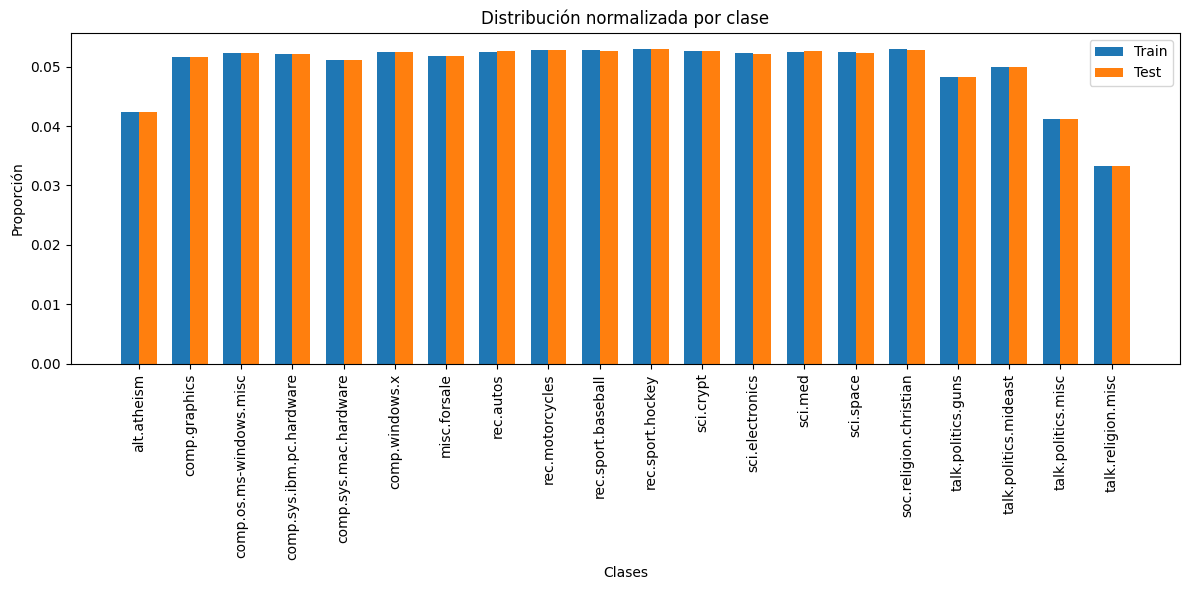

In [7]:
from collections import Counter

# Contar las clases
train_counts = Counter(newsgroups_train.target)
test_counts = Counter(newsgroups_test.target)

# Normalizar las distribuciones de clases
train_normalized = [train_counts.get(i, 0) / ntrain for i in range(nclasses)]
test_normalized = [test_counts.get(i, 0) / ntest for i in range(nclasses)]

# Auxiliar posiciones para las barras
ind = np.arange(len(target_names))
width = 0.35

# Gráfico
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(ind - width/2, train_normalized, width, label='Train')
ax.bar(ind + width/2, test_normalized, width, label='Test')

ax.set_xticks(ind)
ax.set_xticklabels(target_names, rotation=90)
ax.set_xlabel('Clases')
ax.set_ylabel('Proporción')
ax.set_title('Distribución normalizada por clase')
ax.legend()

plt.tight_layout()
plt.show()

**Observaciones**:

- Las clases se encuentran relativamente balanceadas. Si estuviesen perfectamente balanceadas, la fracción de cada clase sería 1/20 = 0.05.

- Se observa que practicamente se mantiene la misma frecuencia de clases para el train y test.

### 1. Vectorización de documentos

Instanciamos el vectorizador TF-IDF

In [8]:
# Instanciamos un vectorizador TF-IDF con parámetros por default
tfidfvect = TfidfVectorizer()

In [9]:
# Accedemos al texto, p.ej., al primer documento del corpus
print(newsgroups_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [10]:
# Aplicamos la vectorización:
X_train = tfidfvect.fit_transform(newsgroups_train.data)        # Matriz documento-términos del voculabulario

In [11]:
print(type(X_train))
print(f'shape: {X_train.shape}')
print(f'Cantidad de documentos: {X_train.shape[0]}')
print(f'Tamaño del vocabulario: {X_train.shape[1]}')

<class 'scipy.sparse._csr.csr_matrix'>
shape: (11314, 101631)
Cantidad de documentos: 11314
Tamaño del vocabulario: 101631


In [12]:
# Generamos un diccionario que va de índices a términos
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

In [13]:
# Guardamos los targets que son enteros
y_train = newsgroups_train.target
y_train[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [19]:
# Definimos una función auxiliar
def get_similar(idx, nmost=5):
    cossim = cosine_similarity(X_train[idx].reshape(1, -1), X_train)[0]
    sorted_idx = np.argsort(cossim)[::-1]
    top_idx = sorted_idx[:nmost + 1]
    data = {
        "CosSimilarity": cossim[top_idx],
        "Doc_idx": top_idx,
        "Target": [newsgroups_train.target_names[y_train[i]] for i in top_idx]
    }

    return pd.DataFrame(data)
    

In [58]:
# Definimos una función auxiliar para evaluar similaridad
def get_similar(idx, nmost=5):
    cossim = cosine_similarity(X_train[idx].reshape(1, -1), X_train)[0]
    sorted_idx = np.argsort(cossim)[::-1]
    top_idx = sorted_idx[:nmost + 1]
    
    # Recupera el target name completo
    full_targets = [newsgroups_train.target_names[y_train[i]] for i in top_idx]
    
    # Separar en sub-clases usando "."
    subclasses = [name.split('.') for name in full_targets]
    
    # Se preparan las columnas, asegurando que tengan al menos 3 partes
    first_class = [parts[0] if len(parts) > 0 else '-' for parts in subclasses]
    second_class = [parts[1] if len(parts) > 1 else '-' for parts in subclasses]
    third_class = [parts[2] if len(parts) > 2 else '-' for parts in subclasses]
    fourth_class = [parts[3] if len(parts) > 3 else '-' for parts in subclasses]
        
    data = {
        "CosSimilarity": cossim[top_idx],
        "Doc_idx": top_idx,
        "First-class": first_class,
        "Second-class": second_class,
        "Third-class": third_class,
        "Fourth-class": fourth_class,
    }
    
    return pd.DataFrame(data)

def plot_frequency(df, column):
    # Obtener instancia de la primera clase
    first_instance_class = df.iloc[0][column]
    
    # Obtener los conteos
    frecuencia = df.iloc[1:][column].value_counts()
    
    # Plot
    
    plt.figure(figsize=(10,6))
    # Asignar color diferente a la clase verdadera
    colores = []
    for val in frecuencia.index:
        if val == first_instance_class:
            colores.append('red')
        else:
            colores.append('blue')  # Otros
    
    barras = frecuencia.plot(kind='bar', color=colores)
    plt.xlabel('Class')
    plt.ylabel('Frecuencia')
    plt.title(f'Frecuencia de valores en la columna "{column}" (resaltando la primera instancia)')
    plt.xticks(rotation=45)
    plt.show()

Index 10476

   CosSimilarity  Doc_idx First-class Second-class Third-class Fourth-class
0       1.000000    10476         rec        sport      hockey            -
1       0.225036     5064         rec        sport      hockey            -
2       0.217432     9623        talk     politics     mideast            -
3       0.216444    10575         sci        crypt           -            -
4       0.212603    10836         alt      atheism           -            -
5       0.211071     2350         sci        crypt           -            -

-------------------------



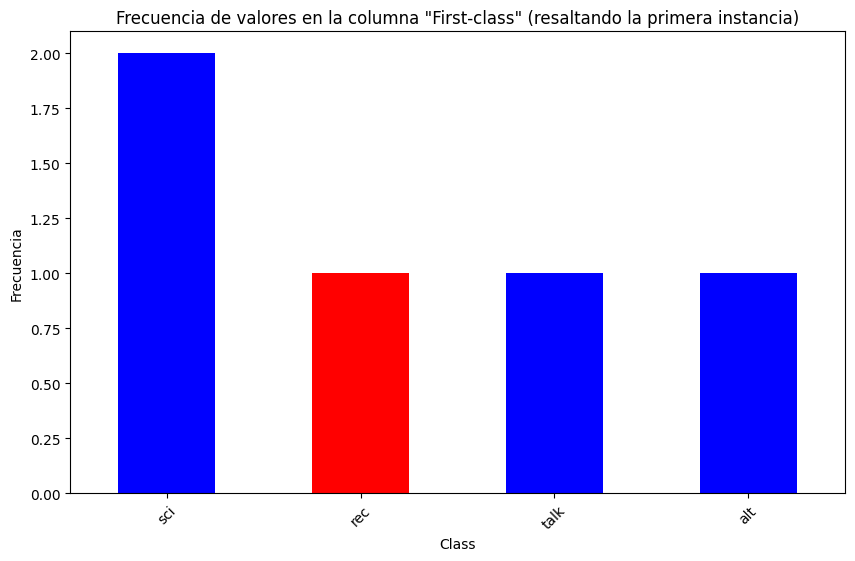

Index 1824

   CosSimilarity  Doc_idx First-class Second-class Third-class Fourth-class
0       1.000000     1824        comp          sys         mac     hardware
1       0.354198     9921        comp          sys         mac     hardware
2       0.313191     6364        comp          sys         mac     hardware
3       0.304137     5509        comp          sys         mac     hardware
4       0.250383     2641        comp          sys         mac     hardware
5       0.241676     4359        comp          sys         mac     hardware

-------------------------



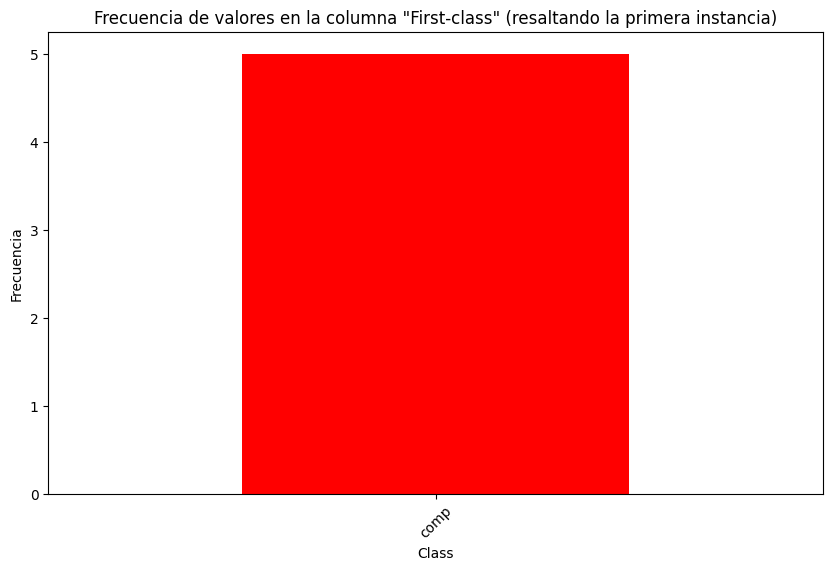

Index 409

   CosSimilarity  Doc_idx First-class Second-class Third-class Fourth-class
0       1.000000      409        comp     graphics           -            -
1       0.230533     3444        comp     graphics           -            -
2       0.209073     5799        comp     graphics           -            -
3       0.198175     5905        comp     graphics           -            -
4       0.183850     1764        comp     graphics           -            -
5       0.165854     3364        comp     graphics           -            -

-------------------------



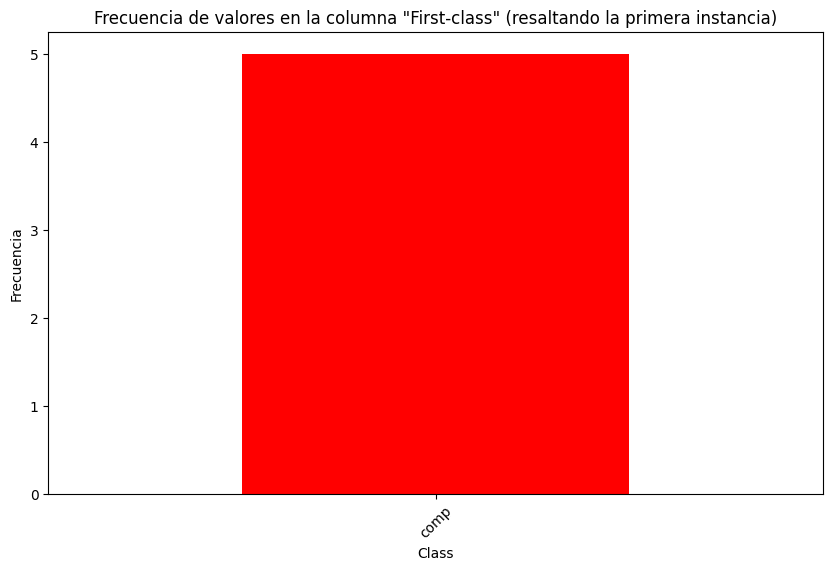

Index 4506

   CosSimilarity  Doc_idx First-class Second-class Third-class Fourth-class
0       1.000000     4506         rec        autos           -            -
1       0.189361     4211         rec  motorcycles           -            -
2       0.168237     5928        comp          sys         mac     hardware
3       0.158334     6224         rec        autos           -            -
4       0.157694     5171         rec        autos           -            -
5       0.152190     9491         rec        autos           -            -

-------------------------



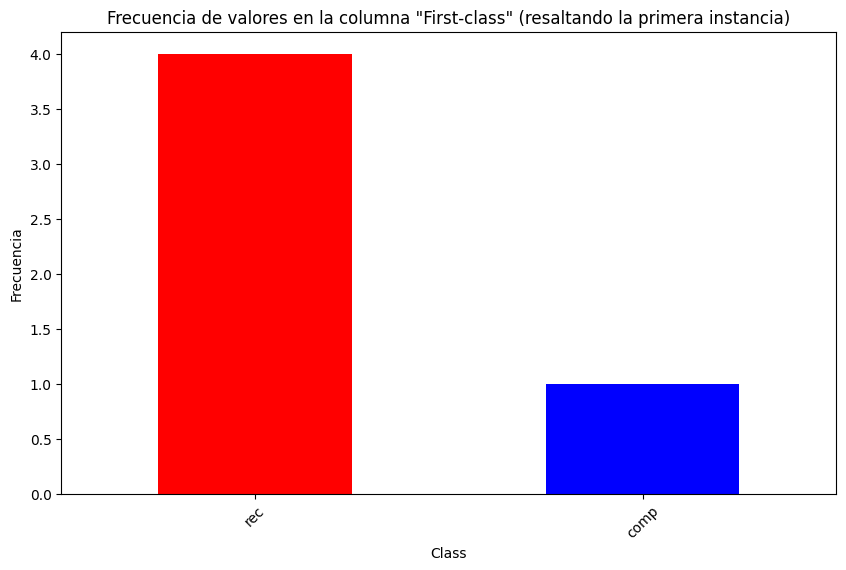

Index 4012

   CosSimilarity  Doc_idx First-class Second-class Third-class Fourth-class
0       1.000000     4012         rec        sport      hockey            -
1       0.160013     6599         soc     religion   christian            -
2       0.142769    10644         rec        sport      hockey            -
3       0.135821     7478         rec        sport      hockey            -
4       0.131774     7308         rec        sport      hockey            -
5       0.130732    10792         rec        sport    baseball            -

-------------------------



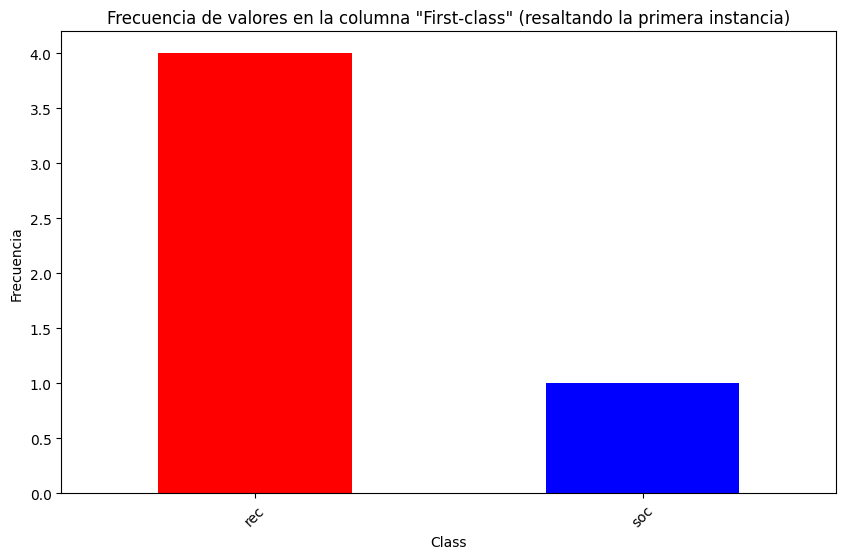

In [59]:
import random as rnd

rnd_seed = 42                                   # Fijamos una semilla para reproducibilidad
rnd.seed(rnd_seed)
rnd_idxs = rnd.sample(range(0, ntrain),5)

for idx in rnd_idxs:
    
    similar = get_similar(idx)
    
    print("Index", idx)
    print("")
    print(get_similar(idx))
    print("")
    print("-------------------------")
    print("")
    
    plot_frequency(similar, column = 'First-class')

**Observaciones**:

- Exceptuando el primer caso, la similaridad coseno de la vectorización TF-IDF resulta una métrica adecuada para determinar si dos documentos pertenecen a la misma clase principal.

### 2. Modelos Naive-Bayes

Entrenamos el modelo usando la vectorización TF-IDF por default:

#### 2.1 Modelo Naive-Bayes Multinomial

In [ ]:
# Instanciamos y entrenamos el modelo
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)

MultinomialNB()

#### 2.2 Modelo Naive-Bayes Complemento

Este modelo resulta adecuado para datasets desbalanceados.

In [ ]:
# Instanciamos y entrenamos el modelo
CNB_model = ComplementNB()
CNB_model.fit(X_train, y_train)

ComplementNB()

#### 2.3 Optimización de hiper-parámetros

Ahora tomamos ambos modelos y tratamos de mejorarlos mediante búsqueda de hiper-parámetros considerando diferentes alternativas de vectorización TF-IDF:

In [ ]:
tfidfvect = TfidfVectorizer(
                            strip_accents = 'ascii',
                            analyzer = 'word', 
                            ngram_range = (1,2),
                            max_df = 0.4,
                            sublinear_tf = True
                        )

X_train = tfidfvect.fit_transform(newsgroups_train.data)        # Matriz documento-términos del voculabulario

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline_NB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

param_grid = {
    'tfidf_use_idf': (True, False),
    'tfidf_sublinear_tf': (True, False),
    'vec_binary': (True, False),
    'tfidf_norm': ('l1','l2'),
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__min_df': [1, 5],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf_alpha': (1, 0.1, 0.01, 0.001, 0.0001)
}

grid_search = GridSearchCV(
    pipeline_NB,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Entrena con tus datos (X: textos, y: etiquetas)
grid_search.fit(X, y)

# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score F1 macro:", grid_search.best_score_)

#### 2.4 Evaluación de métricas

In [ ]:
X_test = vectorizer.transform(newsgroups_test.data)      # Vectorizamos
y_test = newsgroups_test.target                         # Obtenemos targets de testeo

y_pred_nb =  NB_model.predict(X_test)                           
y_pred_cnb =  CNB_model.predict(X_test)                     

ValueError: X has 17 features, but MultinomialNB is expecting 847044 features as input.

In [ ]:
f1_nb = f1_score(y_test, y_pred_nb, average='macro')
f1_cnb = f1_score(y_test, y_pred_cnb, average='macro')

In [ ]:
f1_nb

0.39606731328911404

In [ ]:
f1_cnb

0.6157317225308079

### 3. Similaridad entre palabras

In [ ]:
X_train_T = X_train.T